In [2]:
import os
import glob
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import cv2  # still used to save images out
from decord import VideoReader
from decord import cpu, gpu


### check if number of frames in csv is consistent with frames in video

In [3]:
poses_trials_path = glob.glob("../data/A1/*.csv")
video_trials_path = glob.glob("../data/A1/*.mp4")

In [4]:
poses_trials_path.sort()
video_trials_path.sort()
video_trials_path

['../data/A1/FH0002 25-11-14 14-37-02.mp4',
 '../data/A1/FH0003 25-11-14 14-38-06.mp4',
 '../data/A1/FH0004 25-11-14 14-41-12.mp4',
 '../data/A1/FH0005 25-11-14 14-41-27.mp4',
 '../data/A1/FH0006 25-11-14 14-44-39.mp4',
 '../data/A1/FH0007 25-11-14 14-45-55.mp4',
 '../data/A1/FH0008 25-11-14 14-47-01.mp4',
 '../data/A1/FH0009 25-11-14 14-49-15.mp4',
 '../data/A1/FH0010 25-11-14 14-51-06.mp4',
 '../data/A1/FH0011 25-11-14 14-51-54.mp4',
 '../data/A1/FH0012 25-11-14 14-55-24.mp4',
 '../data/A1/FH0013 25-11-14 14-57-04.mp4',
 '../data/A1/FH0014 25-11-14 14-58-03.mp4',
 '../data/A1/FH0015 25-11-14 15-00-43.mp4',
 '../data/A1/FH0016 25-11-14 15-01-43.mp4',
 '../data/A1/FH0017 25-11-14 15-04-34.mp4',
 '../data/A1/FH0018 25-11-14 15-05-49.mp4',
 '../data/A1/FH0019 25-11-14 15-10-13.mp4',
 '../data/A1/FH0020 25-11-14 15-11-40.mp4',
 '../data/A1/FH0021 25-11-14 15-13-40.mp4',
 '../data/A1/FH0022 25-11-14 15-15-33.mp4',
 '../data/A1/FH0023 25-11-14 15-16-41.mp4',
 '../data/A1/FH0024 25-11-14 15-

In [5]:
def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using decord's VideoReader
    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists

    # load the VideoReader
    vr = VideoReader(video_path, ctx=cpu(0))  # can set to cpu or gpu .. ctx=gpu(0)
                     
    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = len(vr)

    frames_list = list(range(start, end, every))
    saved_count = 0

    if every > 25 and len(frames_list) < 1000:  # this is faster for every > 25 frames and can fit in memory
        frames = vr.get_batch(frames_list).asnumpy()

        for index, frame in zip(frames_list, frames):  # lets loop through the frames until the end
            save_path = os.path.join(frames_dir, video_filename, "{:010d}.jpg".format(index))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # save the extracted image
                saved_count += 1  # increment our counter by one

    else:  # this is faster for every <25 and consumes small memory
        for index in range(start, end):  # lets loop through the frames until the end
            frame = vr[index]  # read an image from the capture
            
            if index % every == 0:  # if this is a frame we want to write out based on the 'every' argument
                save_path = os.path.join(frames_dir, video_filename, "{:010d}.jpg".format(index))  # create the save path
                if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                    cv2.imwrite(save_path, cv2.cvtColor(frame.asnumpy(), cv2.COLOR_RGB2BGR))  # save the extracted image
                    saved_count += 1  # increment our counter by one

    return saved_count  # and return the count of the images we saved

def count_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using decord's VideoReader
    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists

    # load the VideoReader
    vr = VideoReader(video_path, ctx=cpu(0))  # can set to cpu or gpu .. ctx=gpu(0)
                     
    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = len(vr)
        
    return len(vr)  # and return the count of the images we saved


def video_to_frames(video_path, frames_dir, overwrite=False, every=1):
    """
    Extracts the frames from a video
    :param video_path: path to the video
    :param frames_dir: directory to save the frames
    :param overwrite: overwrite frames if they exist?
    :param every: extract every this many frames
    :return: path to the directory where the frames were saved, or None if fails
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    # make directory to save frames, its a sub dir in the frames_dir with the video name
    os.makedirs(os.path.join(frames_dir, video_filename), exist_ok=True)
    
    print("Extracting frames from {}".format(video_filename))
    
    extract_frames(video_path, frames_dir, every=every)  # let's now extract the frames

    return os.path.join(frames_dir, video_filename)  # when done return the directory containing the frames


In [26]:
count_frames(video_trials_path[10], "../data/A_test/frames", overwrite=True, every=1)

320

### head direction vector

In [2]:
poses_trials_path = glob.glob("../data/A_test/*.csv")

In [ ]:
poses_trials_path

#### example for one file

In [30]:
# example file
poses_trial_path = poses_trials_path[3]

In [31]:
# Rearrange csv from Deeplabcut to a more manageable format.
df = pd.read_csv(poses_trial_path, skiprows=1)  # .reset_index(drop=True)
df = df.T.reset_index()
df["index"] = [
    "bodyparts",
    "nose",
    "nose",
    "nose",
    "left_ear",
    "left_ear",
    "left_ear",
    "right_ear",
    "right_ear",
    "right_ear",
]
df = df.set_index(["index", 0])


df.index.names = ["bodyparts", "coords"]
df = df.drop("bodyparts", level=0)
df = df.T
df.index.names = ["frame"]
df.head()

bodyparts                nose                                    \
coords                      x                  y     likelihood   
frame                                                             
1                        -1.0               -1.0           -1.0   
2          244.71627807617188   394.758056640625  0.75537109375   
3          245.49237060546875     392.5751953125  0.75146484375   
4          245.93392944335938  389.4778747558594  0.71142578125   
5          246.52047729492188     388.1240234375  0.73486328125   

bodyparts            left_ear                                        \
coords                      x                   y        likelihood   
frame                                                                 
1                        -1.0                -1.0              -1.0   
2          242.08306884765625  397.29925537109375    0.095947265625   
3           242.9298553466797    395.523681640625  0.07843017578125   
4          241.42221069335938    393.545166015625   0.0911865234375   
5          249.42831420898438    388.099365234375    0.107177734375   

bodyparts          right_ear                                     
coords                     x                  y      likelihood  
frame                                                            
1                       -1.0               -1.0            -1.0  
2          258.0745849609375  397.7348937988281   0.36865234375  
3          258.0767822265625    397.66455078125  0.268798828125  
4          258.1091613769531   397.400634765625   0.23388671875  
5          258.0172119140625  397.3868408203125  0.236083984375

In [ ]:
# Calculate head direction vector
# based on ear and nose positions


# calculate mid point between ears
df[("mid_ears", "x")] = (df[("left_ear", "x")].values.astype(float) + df[("right_ear", "x")].values.astype(float)) / 2
df[("mid_ears", "y")] = (df[("left_ear", "y")].values.astype(float) + df[("right_ear", "y")].values.astype(float)) / 2
df

# calculate head direction vector from mid point between ears to nose as unit vector
head_dir_x = df[("nose", "x")].values.astype(float) - df[("mid_ears", "x")].values.astype(float)
head_dir_y = df[("nose", "y")].values.astype(float) - df[("mid_ears", "y")].values.astype(float)


# calculate vector length of head direction
head_dir_length = (head_dir_x**2 + head_dir_y**2) ** 0.5
# catch frames where DLC put -1 because it couldn't find the body part
pass

# normalize to unit vector
df[("head_direction", "x")] = head_dir_x / head_dir_length
df[("head_direction", "y")] = head_dir_y / head_dir_length
df.head()

/tmp/ipykernel_47074/140594009.py:13: RuntimeWarning: invalid value encountered in divide
  df[("head_direction", "x")] = head_dir_x / head_dir_length
/tmp/ipykernel_47074/140594009.py:14: RuntimeWarning: invalid value encountered in divide
  df[("head_direction", "y")] = head_dir_y / head_dir_length


bodyparts                nose                                    \
coords                      x                  y     likelihood   
frame                                                             
1                        -1.0               -1.0           -1.0   
2          244.71627807617188   394.758056640625  0.75537109375   
3          245.49237060546875     392.5751953125  0.75146484375   
4          245.93392944335938  389.4778747558594  0.71142578125   
5          246.52047729492188     388.1240234375  0.73486328125   

bodyparts            left_ear                                        \
coords                      x                   y        likelihood   
frame                                                                 
1                        -1.0                -1.0              -1.0   
2          242.08306884765625  397.29925537109375    0.095947265625   
3           242.9298553466797    395.523681640625  0.07843017578125   
4          241.42221069335938    393.545166015625   0.0911865234375   
5          249.42831420898438    388.099365234375    0.107177734375   

bodyparts          right_ear                                       mid_ears  \
coords                     x                  y      likelihood           x   
frame                                                                         
1                       -1.0               -1.0            -1.0   -1.000000   
2          258.0745849609375  397.7348937988281   0.36865234375  250.078827   
3          258.0767822265625    397.66455078125  0.268798828125  250.503319   
4          258.1091613769531   397.400634765625   0.23388671875  249.765686   
5          258.0172119140625  397.3868408203125  0.236083984375  253.722763   

bodyparts             head_direction            
coords              y              x         y  
frame                                           
1           -1.000000            NaN       NaN  
2          397.517075      -0.889211 -0.457497  
3          396.594116      -0.780096 -0.625659  
4          395.472900      -0.538549 -0.842594  
5          392.743103      -0.841761 -0.539851

put into function

In [27]:
def calculate_head_direction_vector(file_path):
    # Rearrange csv from Deeplabcut to a more manageable format.
    df = pd.read_csv(file_path, skiprows=1)  # .reset_index(drop=True)
    df = df.T.reset_index()
    df["index"] = [
        "bodyparts",
        "nose",
        "nose",
        "nose",
        "left_ear",
        "left_ear",
        "left_ear",
        "right_ear",
        "right_ear",
        "right_ear",
    ]
    df = df.set_index(["index", 0])

    df.index.names = ["bodyparts", "coords"]
    df = df.drop("bodyparts", level=0)
    df = df.T
    df.index.names = ["frame"]

    # calculate mid point between ears
    df[("mid_ears", "x")] = (df[("left_ear", "x")].values.astype(float) + df[("right_ear", "x")].values.astype(float)) / 2
    df[("mid_ears", "y")] = (df[("left_ear", "y")].values.astype(float) + df[("right_ear", "y")].values.astype(float)) / 2

    # calculate head direction vector from mid point between ears to nose as unit vector
    head_dir_x = df[("nose", "x")].values.astype(float) - df[("mid_ears", "x")].values.astype(float)
    head_dir_y = df[("nose", "y")].values.astype(float) - df[("mid_ears", "y")].values.astype(float)
    head_dir_length = (head_dir_x**2 + head_dir_y**2) ** 0.5
    
    assert np.all(head_dir_length > 0.0001), f"Head direction length is zero in file {file_path}."

    df[("head_direction", "x")] = head_dir_x / head_dir_length
    df[("head_direction", "y")] = head_dir_y / head_dir_length


    return df

#### do for all files
concat all data of one mouse into a single DataFrame

In [28]:
poses_trials = list()
for file_path in poses_trials_path:
    df = calculate_head_direction_vector(file_path)
    poses_trials.append(df)

AssertionError: Head direction length is zero in file ../data/A_test/cut16DLC_HrnetW32_HD3Nov5shuffle1_detector_200_snapshot_010.csv.

### Place avoidance

### Looking over table rim

### Relative rückweg Geschwindigkeit

### get sound timepoints

In [ ]:
# list all .mat files in a directory
mat_files = glob.glob(os.path.join("../A1/", "*.mat"))
mat_files

['../A1/Data2.mat',
 '../A1/Data18.mat',
 '../A1/Data13.mat',
 '../A1/Data21.mat',
 '../A1/Data23.mat',
 '../A1/Data1.mat',
 '../A1/Data3.mat',
 '../A1/Data10.mat',
 '../A1/Data25.mat',
 '../A1/Data22.mat',
 '../A1/Data12.mat',
 '../A1/Data11.mat',
 '../A1/Data19.mat',
 '../A1/Data15.mat',
 '../A1/Data16.mat',
 '../A1/Data4.mat',
 '../A1/Data9.mat',
 '../A1/Data20.mat',
 '../A1/Data14.mat',
 '../A1/Data6.mat',
 '../A1/Data8.mat',
 '../A1/Data17.mat',
 '../A1/Data5.mat',
 '../A1/Data24.mat',
 '../A1/Data7.mat']

In [ ]:
# import .mat with h5py

f = h5py.File(mat_files[15], 'r')
f

<HDF5 file "Data4.mat" (mode r)>

In [ ]:
f.keys()

<KeysViewHDF5 ['Ch1', 'Ch2', 'Ch3', 'Ch31', 'Ch32', 'Ch4', 'Ch5', 'Ch6', 'file']>

In [ ]:
ch4 = f["Ch4"]
ch4.keys()

<KeysViewHDF5 ['comment', 'interval', 'length', 'offset', 'scale', 'start', 'times', 'title', 'units', 'values']>

In [ ]:
t = np.array(ch4["times"][:]).flatten()
vals = np.array(ch4["values"][:]).flatten()

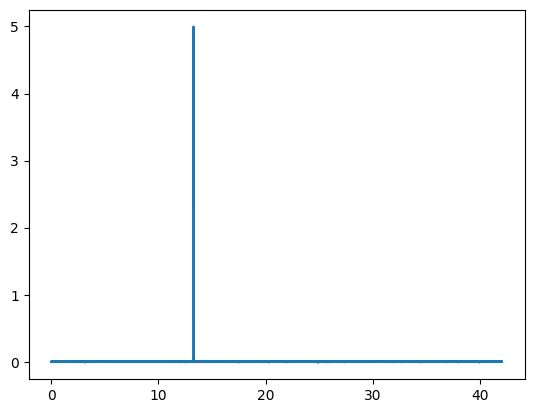

In [ ]:
plt.plot(t, vals)

In [ ]:
ch3 = f["Ch3"]
ch3.keys()

<KeysViewHDF5 ['comment', 'interval', 'length', 'offset', 'scale', 'start', 'times', 'title', 'units', 'values']>

In [ ]:
t = np.array(ch3["times"][:]).flatten()
vals = np.array(ch3["values"][:]).flatten()

In [ ]:
# get index of video onset
np.where(np.diff(vals) > 1)[0][0]

36165